In [1]:
from collections import defaultdict
import math
import pandas as pd
import numpy as np
import os
import random
import gc
import cv2
import glob
gc.enable()
pd.set_option('display.max_columns', None)

# Visialisation
import matplotlib.pyplot as plt
%matplotlib inline

# Image Aug
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# Deep Learning
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

import os
import sys
import gc
import subprocess
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Video, display
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from scipy.optimize import minimize
import cv2
from glob import glob
from tqdm.notebook import tqdm

#from tqdm import tqdm
import time
from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger
from sklearn.metrics import f1_score

In [2]:
class CFG:
    exp_name = "ex2"
    datapath = "/tmp/hdd/cat/cat_v1/"
    output_dir =  "/tmp/hdd/cat/output/"+exp_name+"/"
    seed = 42
    model_name = "tf_efficientnet_b0"
    batch_size = 16
    epochs=1
    gpu = [0]
    max_lr=1e-3
    weight_decay=1e-4
    n_fold=3
    trn_fold=[0, 1, 2]
    apex = True
    num_workers=0
    print_freq=50
    
    
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu[0]}")
        print(device)
    else:
        CFG.device = torch.device("cpu")
        print("does not use GPU")

cuda:0


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def get_logger(filename):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def make_dir(CFG):
    if not os.path.exists(CFG.output_dir):
        os.makedirs(CFG.output_dir)
    
make_dir(CFG)
seed_everything(CFG.seed)
LOGGER = get_logger(CFG.output_dir + "train")

In [4]:
def get_csv():
    cat_categories = []
    path = CFG.datapath
    for directory in os.listdir(path):
        if '.' not in directory:
            cat_categories.append(directory)
            
    image_directory = {}
    for i in cat_categories:
        image_directory[i] = [os.path.join(path,i,j) for j in  os.listdir(os.path.join(path,i))]
        
    file_category = []
    file_name = []
    for i in image_directory.keys():
        for j in image_directory[i]:
            file_category.append(i)
            file_name.append(j)

    data = {"categories":file_category,"file_name":file_name}
    
    return cat_categories,pd.DataFrame(data)

In [5]:
cat_categories,train_df = get_csv()

ragdoll
/tmp/hdd/cat/cat_v1/ragdoll/86 (1).jpg


Text(0.5, 1.0, 'ragdoll')

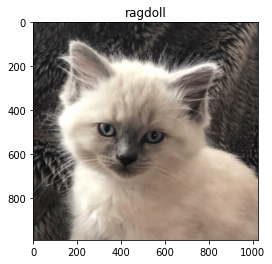

In [6]:
x = train_df.sample()
random_category = x.categories.values[0]
random_file_name = x.file_name.values[0]
print(random_category)
print(random_file_name)
img = PIL.Image.open(random_file_name)
plt.imshow(img)
plt.title(random_category)

In [7]:
str_to_int = {}
for i in range(len(cat_categories)):
    str_to_int[cat_categories[i]]=i
    
print(str_to_int)

{'ragdoll': 0, 'siamese': 1, 'domestic_shorthair': 2, 'bengal': 3, 'maine_coon': 4}


In [8]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train_df, train_df['categories'])):
    train_df.loc[val_index, 'fold'] = int(n)
train_df['fold'] = train_df['fold'].astype(int)

In [9]:
class CatDataset(Dataset):
    def __init__(self,cfg, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image_path = self.data['file_name'][idx]
        image = PIL.Image.open(image_path)
        category_name = self.data['categories'][idx]
        label = str_to_int[category_name]
        
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image,label

In [10]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_aug =T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [11]:
class CustomModel(nn.Module):
    def __init__(
        self, cfg=CFG, n_class=5, pretrained=False
    ):
        super().__init__()
        self.backbone = timm.create_model(
            cfg.model_name, pretrained=pretrained, num_classes = 0)
        
        self.in_features = self.backbone.num_features
        self.head = nn.Sequential(
                    nn.Linear(self.in_features, 1024),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(1024, 512),
                    nn.Dropout(),
                    nn.Linear(512, n_class)
                    )
        
    def feature(self,x):
        features = self.backbone(x)
        return features

    def forward(self, x):
        backbone_features = self.feature(x)
        x = self.head(backbone_features)
        output = x
        return output

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def get_score(y_true, y_pred):
    score=f1_score(y_true, y_pred, average='macro')
    return score

In [13]:
def _fit_train(
    fold, train_loader, model, criterion, optimizer, epoch, scheduler, CFG
):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    loss_meter = AverageMeter()
    start = end = time.time()
    t = tqdm(train_loader, total=len(train_loader))

    for step, data in enumerate(t):
        image,label = data

        image = image.to(CFG.device)
        label = label.to(CFG.device)
        batch_size = label.size(0)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            output = model(image)
        loss = criterion(output, label) 
        loss_meter.update(loss.data)
        t.set_description("[ loss: {:.4f} ]".format(loss_meter.avg))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=loss_meter,
                          lr=scheduler.get_last_lr()[0]))
        scheduler.step()

    return loss_meter.avg

In [14]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    target = []
    start = end = time.time()
    t = tqdm(valid_loader, total=len(valid_loader))
    for step, data in enumerate(t):
        image,label = data

        image = image.to(CFG.device)
        label = label.to(CFG.device)
        with torch.no_grad():
            y_preds = model(image)
        loss = criterion(y_preds, label)
        losses.update(loss)
        pred=torch.argmax(y_preds,dim=1).detach().to('cpu').numpy()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
        preds.extend(pred)
        target.extend(label.detach().to('cpu').numpy())
    return losses.avg, preds,target

In [15]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['categories'].values
    
    train_dataset = CatDataset(CFG, train_folds,transform=train_aug)
    valid_dataset = CatDataset(CFG, valid_folds,transform=train_aug)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=False)
    model.to(CFG.device)
    
    optimizer = torch.optim.AdamW(
            model.parameters(), lr=CFG.max_lr, weight_decay=CFG.weight_decay
        )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, CFG.max_lr, epochs=CFG.epochs, steps_per_epoch=len(train_loader)
        )
    criterion = nn.CrossEntropyLoss()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = _fit_train(fold, train_loader, model, criterion, optimizer, epoch, scheduler, CFG)

        # eval
        avg_val_loss, predictions, target = valid_fn(valid_loader, model, criterion, CFG.device)
        
#         # scoring
        score = get_score(target, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        CFG.output_dir+f"{CFG.model_name.replace('/', '-')}_fold{fold}_best.pth")
            
    predictions = torch.load(CFG.output_dir+f"{CFG.model_name.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [16]:
# oof_df = pd.DataFrame()
# for fold in range(CFG.n_fold):
#     if fold in CFG.trn_fold:
#         _oof_df= train_loop(train_df, fold)
#         oof_df = pd.concat([oof_df, _oof_df])
# oof_df = oof_df.reset_index(drop=True)
# a = oof_df.replace(str_to_int,)

In [17]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['categories']
        pred =oof_df['pred']
        score=get_score(labels, pred)
        LOGGER.info(f'Score: {score:<.4f}')
        

    oof_df = pd.DataFrame()
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            _oof_df= train_loop(train_df, fold)
            oof_df = pd.concat([oof_df, _oof_df])
    oof_df = oof_df.reset_index(drop=True)
    oof_df = oof_df.replace(str_to_int)
    
    get_result(oof_df)
    oof_df.to_pickle(CFG.output_dir+f"{CFG.exp_name}_oof_df.pkl")

========== fold: 0 training ==========


Epoch: [1][0/39] Elapsed 0m 1s (remain 1m 11s) Loss: 1.6133(1.6133) LR: 0.00004000  


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][38/39] Elapsed 0m 29s (remain 0m 0s) Loss: 1.6543(1.5889) LR: 0.00000000  



EVAL: [0/20] Elapsed 0m 0s (remain 0m 11s) Loss: 0.7281(0.7281) 


Epoch 1 - avg_train_loss: 1.5889  avg_val_loss: 1.7904  time: 42s
Epoch 1 - Score: 0.1392
Epoch 1 - Save Best Score: 0.1392 Model


EVAL: [19/20] Elapsed 0m 12s (remain 0m 0s) Loss: 2.2229(1.7904) 



========== fold: 1 training ==========


Epoch: [1][0/39] Elapsed 0m 0s (remain 0m 31s) Loss: 1.5918(1.5918) LR: 0.00004000  


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][38/39] Elapsed 0m 27s (remain 0m 0s) Loss: 1.3623(1.6133) LR: 0.00000000  



EVAL: [0/20] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7015(0.7015) 


Epoch 1 - avg_train_loss: 1.6133  avg_val_loss: 1.9566  time: 40s
Epoch 1 - Score: 0.0968
Epoch 1 - Save Best Score: 0.0968 Model


EVAL: [19/20] Elapsed 0m 12s (remain 0m 0s) Loss: 2.4111(1.9566) 



========== fold: 2 training ==========


Epoch: [1][0/39] Elapsed 0m 0s (remain 0m 30s) Loss: 1.6172(1.6172) LR: 0.00004000  


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][38/39] Elapsed 0m 28s (remain 0m 0s) Loss: 1.7861(1.5742) LR: 0.00000000  



EVAL: [0/20] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4471(0.4471) 


Epoch 1 - avg_train_loss: 1.5742  avg_val_loss: 1.8951  time: 41s
Epoch 1 - Score: 0.0805
Epoch 1 - Save Best Score: 0.0805 Model


EVAL: [19/20] Elapsed 0m 12s (remain 0m 0s) Loss: 2.2357(1.8951) 



Score: 0.1074
